In [1]:
import os
import pre_processing_utils
import numpy as np
import pandas as pd
from matplotlib.image import imread
from tensorflow.keras.metrics import AUC as auc
import seaborn as sns
import matplotlib.pyplot as plt

<h2>Data Pre-Processing</h2>

In [2]:
pre_processing_utils.check_data_exists()

test data location = ./chest_xray/test
training data location = ./chest_xray/train
validation data location = ./chest_xray/val


<h2>Data Pre-Processing</h2>

In [3]:
# We're going to have images of different dimensions, so handle that before using the CNN
dim1_mean, dim2_mean = pre_processing.get_average_dimensions()
image_shape = (300, 300, 3)

In [8]:
# Going to get the mean image size and resize to that
print('Dimension 1 Mean = {}'.format(dim1_mean))
print('Dimension 2 Mean = {}'.format(dim2_mean))

Dimension 1 Mean = 971.0
Dimension 2 Mean = 1277.0


In [9]:
pre_processing_utils.flipImages()

Performing flip transformations: 
Data-Directories Transformed: 100%|██████████| 6/6 [05:37<00:00, 56.32s/ DIR]


In [ ]:
pre_processing_utils.rotateImages()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(horizontal_flip=True,
                               fill_mode='nearest')

In [85]:
image_gen.flow_from_directory(train_path)

Found 5216 images belonging to 2 classes.


In [43]:
image_gen.flow_from_directory(test_path)

Found 624 images belonging to 2 classes.


In [44]:
image_gen.flow_from_directory(val_path)

Found 16 images belonging to 2 classes.


<h2>Building a Model</h2>

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.metrics import Accuracy, AUC

In [49]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=[AUC()])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)            

<h2>Regularization</h2>

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
batch_size = 64

In [53]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [54]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode='binary',
                                               shuffle=False) # Don't want to shuffle test data and lose labels

Found 624 images belonging to 2 classes.


In [55]:
test_image_gen.class_indices

{'normal': 0, 'pneumonia': 1}

<h3>Running the Model</h3>

In [57]:
# Running without early stop for now - not enough examples for 'val_loss'?
results = model.fit(train_image_gen, epochs=20,
                             validation_data=test_image_gen,
                    callbacks=[early_stop]
                   )

Train for 82 steps, validate for 10 steps
Epoch 1/20
82/82 [==============================] - 466s 6s/step - loss: 0.1765 - accuracy: 0.9369 - val_loss: 0.8679 - val_accuracy: 0.7676
Epoch 2/20
82/82 [==============================] - 466s 6s/step - loss: 0.2305 - accuracy: 0.9099 - val_loss: 0.8993 - val_accuracy: 0.7500
Epoch 3/20
82/82 [==============================] - 471s 6s/step - loss: 0.2082 - accuracy: 0.9185 - val_loss: 0.9638 - val_accuracy: 0.7660


In [58]:
metrics = pd.DataFrame(model.history.history)

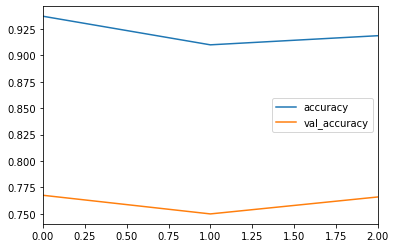

In [59]:
metrics[['accuracy', 'val_accuracy']].plot()

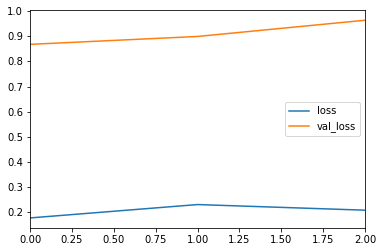

In [60]:
metrics[['auc', 'val_auc']].plot()

In [ ]:
metrics[['loss', 'val_loss']].plot()

<p>We see that the model is overfitting significantly.</p>

In [ ]:
model.save('image_classifier_accuracy.h5')